In [7]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re                            #Helps to remove unnecessary symbols that do not provide any meaning such as @, comma, hashtags, *,etc.
import string
from nltk.corpus import stopwords    #removes stop words, lemmatize the sentences, and many different functions can be performed using NLTK.
from wordcloud import WordCloud

#importing libraries for model building and evaluation
from tensorflow.keras.preprocessing.text import Tokenizer      #Used to split text into individual units, such as words or sub words which make it easier to analyze and process text for various language-related tasks.
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix


# REPRESENTATION OF DATASET

In [8]:
import json
import pandas as pd

data = []
with open('/content/Sarcasm_Headlines_Dataset.json', 'r') as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue  # Skip lines that cannot be parsed

df = pd.DataFrame(data)
print(df.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


<ipython-input-37-68f26533426f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_sarcastic', data=df, palette="summer").set_title(


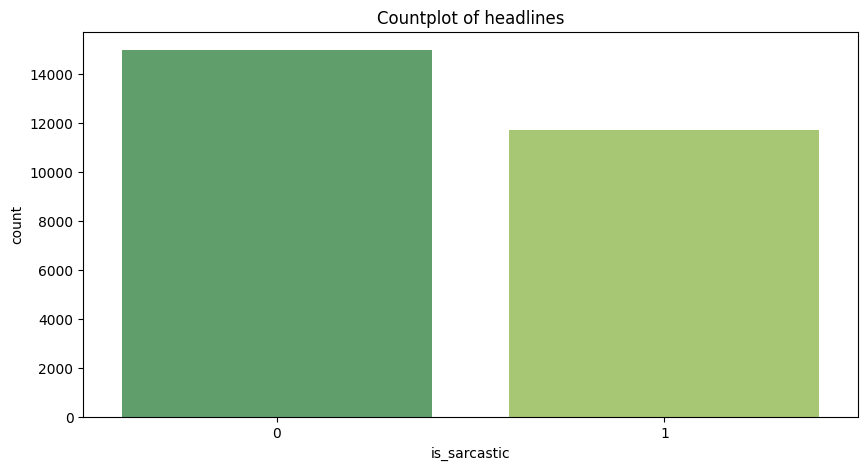

In [37]:
# Check the dataset label balance or not

# Check number of headlines by is_sarcastics
plt.figure(figsize=(10, 5))
sns.countplot(x='is_sarcastic', data=df, palette="summer").set_title(
	"Countplot of headlines")
plt.show()


In [11]:
#downloading the stopwords corpus list
import nltk


nltk.download('stopwords')
stopwords_list = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def clean_text(sentences):
	# convert text to lowercase
	text = sentences.lower()
	# remove text in square brackets
	text = re.sub('\[.*?\]', '', text)
	# removing punctuations
	text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
	# removing words containing digits
	text = re.sub('\w*\d\w*', '', text)
	# Join the words
	text = ' '.join([word for word in text.split()
					if word not in stopwords_list])
	return text


print(df['headline'].iloc[1])
clean_text(df['headline'].iloc[1])


the 'roseanne' revival catches up to our thorny political mood, for better and worse


'roseanne revival catches thorny political mood better worse'

In [13]:
#new column to store cleaned text
df['cleaned_headline']=df['headline'].map(clean_text)


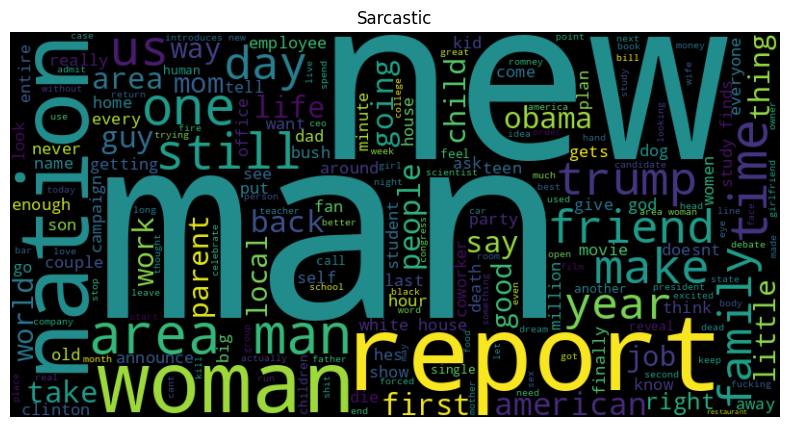

In [39]:
# Combine all sarcastic cleaned headlines into a single text
import matplotlib.pyplot as plt
from wordcloud import WordCloud
Sarcastic_text = ' '.join(
	df['cleaned_headline'][df['is_sarcastic'] == 1].tolist())

# Import the necessary libraries

# Create a WordCloud object with specified width, height, and background color
wordcloud = WordCloud(width=800, height=400,
					background_color='black').generate(Sarcastic_text)

# Display the WordCloud without axes
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sarcastic')
plt.show()


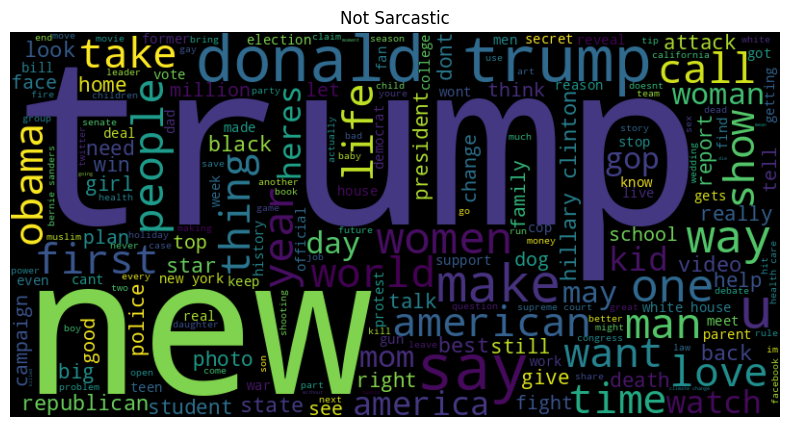

In [15]:
# Combine all non-sarcastic cleaned headlines into a single text
Non_Sarcastic_text = ' '.join(
	df['cleaned_headline'][df['is_sarcastic'] == 0].tolist())

# Create a WordCloud object with specified width, height, and background color
wordcloud = WordCloud(width=800, height=400,
					background_color='black').generate(Non_Sarcastic_text)

# Display the WordCloud without axes
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not Sarcastic')
plt.show()


# **TRAINING OF THE MODEL**

In [17]:
#coverting the columns into lists
text = df['cleaned_headline'].tolist()
label = df['is_sarcastic'].tolist()


In [18]:
# train :test : validation = 80:10:10
train_portion = .8

# Set the train size using training_portion arg
train_size = int(len(text) * train_portion)

# Training dataset
train_text = text[:train_size]
train_label = label[:train_size]
# Validations dataset
valid_size = train_size+int((len(text)-train_size)/2)
val_text = text[train_size:valid_size]
val_label = label[train_size:valid_size]
# Testing dataset
test_text = text[valid_size:]
test_label = label[valid_size:]

# Check
print('Training data :', len(train_text), len(train_label))
print('Validations data :', len(val_text), len(val_label))
print('Testing data :', len(test_text), len(test_label))


Training data : 21367 21367
Validations data : 2671 2671
Testing data : 2671 2671


In [19]:
# Set parameters
# Max len of unique words
vocab_size = 10000

# Embedding dimension value
embedding_dim = 200

# Max length of sentence
max_length = 60

# pad_sequences arg
padding_type = 'post'

# Unknow words = <OOV>
oov_tok = '<OOV>'

# Tokenizing and padding
# Create a tokenizer with a specified vocabulary size and out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fit the tokenizer on the training text data to create word-to-index mapping
tokenizer.fit_on_texts(train_text)


In [20]:
# Get the word index from the tokenizer
word_index = tokenizer.word_index

#Printing the word_index
word_index


{'<OOV>': 1,
 'new': 2,
 'trump': 3,
 'man': 4,
 'us': 5,
 'one': 6,
 'report': 7,
 'area': 8,
 'donald': 9,
 'says': 10,
 'woman': 11,
 'day': 12,
 'get': 13,
 'time': 14,
 'first': 15,
 'like': 16,
 'trumps': 17,
 'people': 18,
 'obama': 19,
 'life': 20,
 'house': 21,
 'women': 22,
 'back': 23,
 'still': 24,
 'make': 25,
 'white': 26,
 'clinton': 27,
 'americans': 28,
 'could': 29,
 'world': 30,
 'years': 31,
 'way': 32,
 'family': 33,
 'study': 34,
 'black': 35,
 'gop': 36,
 'bill': 37,
 'best': 38,
 'show': 39,
 'watch': 40,
 'would': 41,
 'really': 42,
 'president': 43,
 'police': 44,
 'things': 45,
 'know': 46,
 'finds': 47,
 'cant': 48,
 'good': 49,
 'video': 50,
 'going': 51,
 'death': 52,
 'love': 53,
 'school': 54,
 'american': 55,
 'hillary': 56,
 'year': 57,
 'home': 58,
 'nation': 59,
 'health': 60,
 'last': 61,
 'may': 62,
 'state': 63,
 'need': 64,
 'parents': 65,
 'every': 66,
 'say': 67,
 'big': 68,
 'gets': 69,
 'work': 70,
 'take': 71,
 'campaign': 72,
 'little': 73,

In [21]:
# Convert training text to sequences of word indices
tokenizer.texts_to_sequences(train_text[:5])


[[210, 1, 696, 3721, 2158, 258, 35, 1692, 2535, 8801],
 [6811, 2794, 2795, 8802, 259, 2536, 153, 787],
 [74, 788, 617, 789, 1897, 470, 4774, 120, 8803],
 [1195, 121, 286, 1410, 184, 2537, 1, 753],
 [4775, 5602, 861, 8804, 485, 440, 1141, 32]]

In [22]:
# Tokenize and pad the training text data
# Convert training text to sequences of word indices
train_indices = tokenizer.texts_to_sequences(train_text)
# Pad sequences to a fixed length
train_padded = pad_sequences(train_indices,
							padding=padding_type,
							maxlen=max_length)


In [23]:
# Convert validation text to sequences of word indices
val_indices = tokenizer.texts_to_sequences(val_text)
# Pad sequences to a fixed length
validation_padded = pad_sequences(val_indices,
								padding=padding_type,
								maxlen=max_length)

# Convert test text to sequences of word indices
test_indices = tokenizer.texts_to_sequences(test_text)
# Pad sequences to a fixed length
test_padded = pad_sequences(test_indices,
							padding=padding_type,
							maxlen=max_length)

# Check
print('Training vector :', train_padded.shape)
print('Validations vector :', validation_padded.shape)
print('Testing vector :', test_padded.shape)


Training vector : (21367, 60)
Validations vector : (2671, 60)
Testing vector : (2671, 60)


In [24]:
# Decode the sample training vector
tokenizer.sequences_to_texts([train_padded[0].tolist()])


['former <OOV> store clerk sues secret black code minority shoppers <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [25]:
# Prepare labels for model
training_labels_final = np.array(train_label)
validation_labels_final = np.array(val_label)
testing_labels_final = np.array(test_label)


# Check shapes
print('Training vector :', training_labels_final.shape)
print('Validations vector :', validation_labels_final.shape)
print('Testing vector :', testing_labels_final.shape)


Training vector : (21367,)
Validations vector : (2671,)
Testing vector : (2671,)


In [27]:
# Import the TensorFlow library
import tensorflow as tf

# Define a sequential neural network model
model = tf.keras.Sequential([
	# Embedding layer for creating word embeddings
	tf.keras.layers.Embedding(
		vocab_size, embedding_dim, input_length=max_length),

	# GlobalMaxPooling layer to extract relevant features
	tf.keras.layers.GlobalMaxPool1D(),

	# First Dense layer with 40 neurons and ReLU activation
	tf.keras.layers.Dense(40, activation='relu'),

	# Dropout layer to prevent overfitting
	tf.keras.layers.Dropout(0.5),

	# Second Dense layer with 20 neurons and ReLU activation
	tf.keras.layers.Dense(20, activation='relu'),

	# Dropout layer to prevent overfitting
	tf.keras.layers.Dropout(0.5),

	# Third Dense layer with 10 neurons and ReLU activation
	tf.keras.layers.Dense(10, activation='relu'),

	# Dropout layer to prevent overfitting
	tf.keras.layers.Dropout(0.2),

	# Final Dense layer with 1 neuron and sigmoid activation for binary classification
	tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile the model with specified loss function, optimizer, and evaluation metrics
model.compile(loss='binary_crossentropy',
			optimizer='adam', metrics=['accuracy'])


In [29]:
# Set the number of training epochs
num_epochs = 5

# Fit the model to the training data and validate on the validation data
history = model.fit(
	train_padded, training_labels_final,
	epochs=num_epochs,
	validation_data=(validation_padded, validation_labels_final)
)


Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.5851 - loss: 0.6615 - val_accuracy: 0.7806 - val_loss: 0.4660
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8545 - loss: 0.3792 - val_accuracy: 0.7978 - val_loss: 0.4554
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.9301 - loss: 0.2156 - val_accuracy: 0.8034 - val_loss: 0.5420
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.9665 - loss: 0.1066 - val_accuracy: 0.8034 - val_loss: 0.7527
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.9844 - loss: 0.0558 - val_accuracy: 0.7982 - val_loss: 1.1110


# LOSS AND ACCURACY

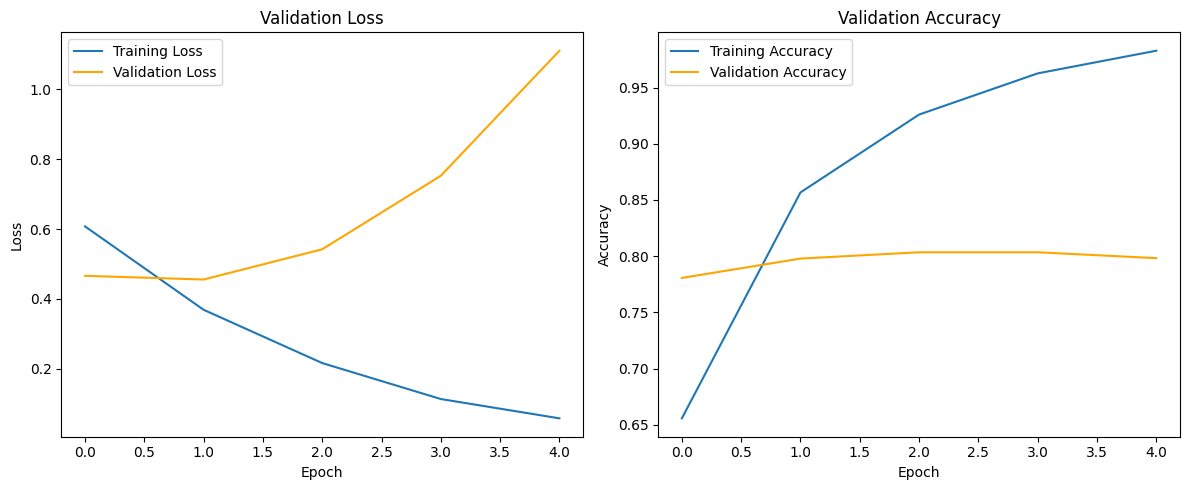

In [30]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss',color='orange')
ax1.set_title('Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [31]:
#evaluating loss and accuray of the model
loss, accuracy = model.evaluate(test_padded,testing_labels_final)
print(f'Accurcy on test dataset :{round(accuracy*100,2)}%')


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7921 - loss: 1.0185
Accurcy on test dataset :79.37%


In [32]:
#predicting the model

pred_prob = model.predict(test_padded)
pred_label = [1 if prob >= 0.5 else 0 for prob in pred_prob]
pred_label[:5]


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[1, 0, 0, 1, 0]

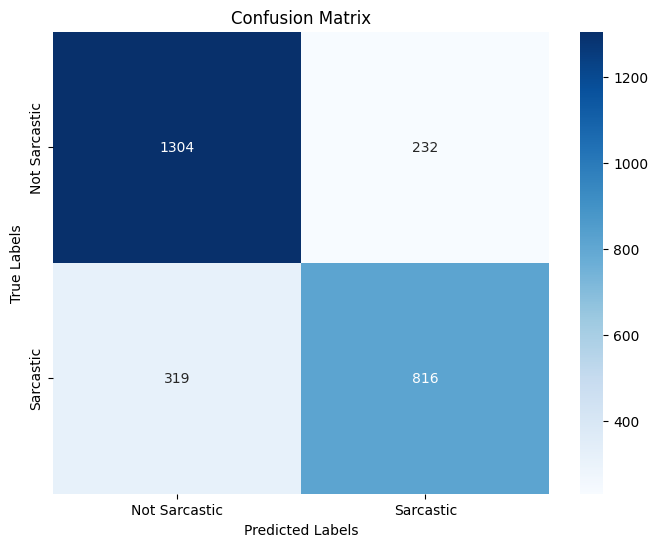

In [33]:
# Compute confusion matrix using the predicted classes and true labels
conf_matrix = confusion_matrix(testing_labels_final, pred_label)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
			xticklabels=['Not Sarcastic', 'Sarcastic'],
			yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# Print Classification Report
print("\nClassification Report:")
print(classification_report(testing_labels_final, pred_label,
							target_names=['Not Sarcastic', 'Sarcastic']))



Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.80      0.85      0.83      1536
    Sarcastic       0.78      0.72      0.75      1135

     accuracy                           0.79      2671
    macro avg       0.79      0.78      0.79      2671
 weighted avg       0.79      0.79      0.79      2671



In [35]:
while True:
	# Prompt the user to input a headline or exit
	user_input = input(
		"Enter a headline for prediction (or type 'exit' to quit): ")

	# Check if the user wants to exit
	if user_input.lower() == 'exit':
		break

	# Clean and preprocess user input
	cleaned_input = clean_text(user_input)
	tokenized_input = tokenizer.texts_to_sequences(
		[cleaned_input]) # Tokenize the cleaned text
	padded_input = pad_sequences(
		tokenized_input, maxlen=max_length, padding=padding_type) # Pad the tokenized text

	# Predict sarcasm
	prediction = model.predict(padded_input)

	# Print the prediction result
	if prediction >= 0.5:
		print(f"Headline: {user_input}\nPrediction: Sarcastic")
	else:
		print(f"Headline: {user_input}\nPrediction: Not Sarcastic")


Enter a headline for prediction (or type 'exit' to quit): Hello, what's happening now?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Headline: Hello, what's happening now?
Prediction: Not Sarcastic
Enter a headline for prediction (or type 'exit' to quit): hey, can you not cry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Headline: hey, can you not cry
Prediction: Not Sarcastic
Enter a headline for prediction (or type 'exit' to quit): cleaning the city?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Headline: cleaning the city?
Prediction: Not Sarcastic
Enter a headline for prediction (or type 'exit' to quit): can you be more bad?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Headline: can you be more bad?
Prediction: Not Sarcastic
Enter a headline for prediction (or type 'exit' to quit): yeah sure
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Headline: yeah sure
Prediction: Sarcastic
Enter a headline for prediction (or type 'exit' to quit): ofcourse not
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Headline: ofcourse not
Prediction: 